In [26]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [27]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

        age — возраст основного бенефициара;

        sex — пол страхового подрядчика;

        bmi — индекс массы тела (\(кг/м^{2}\)), в идеале — от 18.5 до 24.9;

        children — количество детей, охваченных медицинской страховкой;

        smoker — является ли человек курящим;

        region — жилой район США (северо-восток, юго-восток, северо-запад, юго-запад);

        charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.
        


In [28]:
print(data.shape)

(1338, 7)


In [29]:
# Выведем информацию о пропусках
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [30]:
# Выведем информацию о типах данных
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [31]:
display(data.describe())

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [32]:
display(data.describe(include='object'))

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


# 1 Итерация

In [33]:
# Создадим копию данных
temp_data = data.copy()

In [34]:
# Выделяем числовые переменные
type = temp_data.dtypes
num_type = list(type[(type != 'object')].index)
num_type

['age', 'bmi', 'children', 'charges']

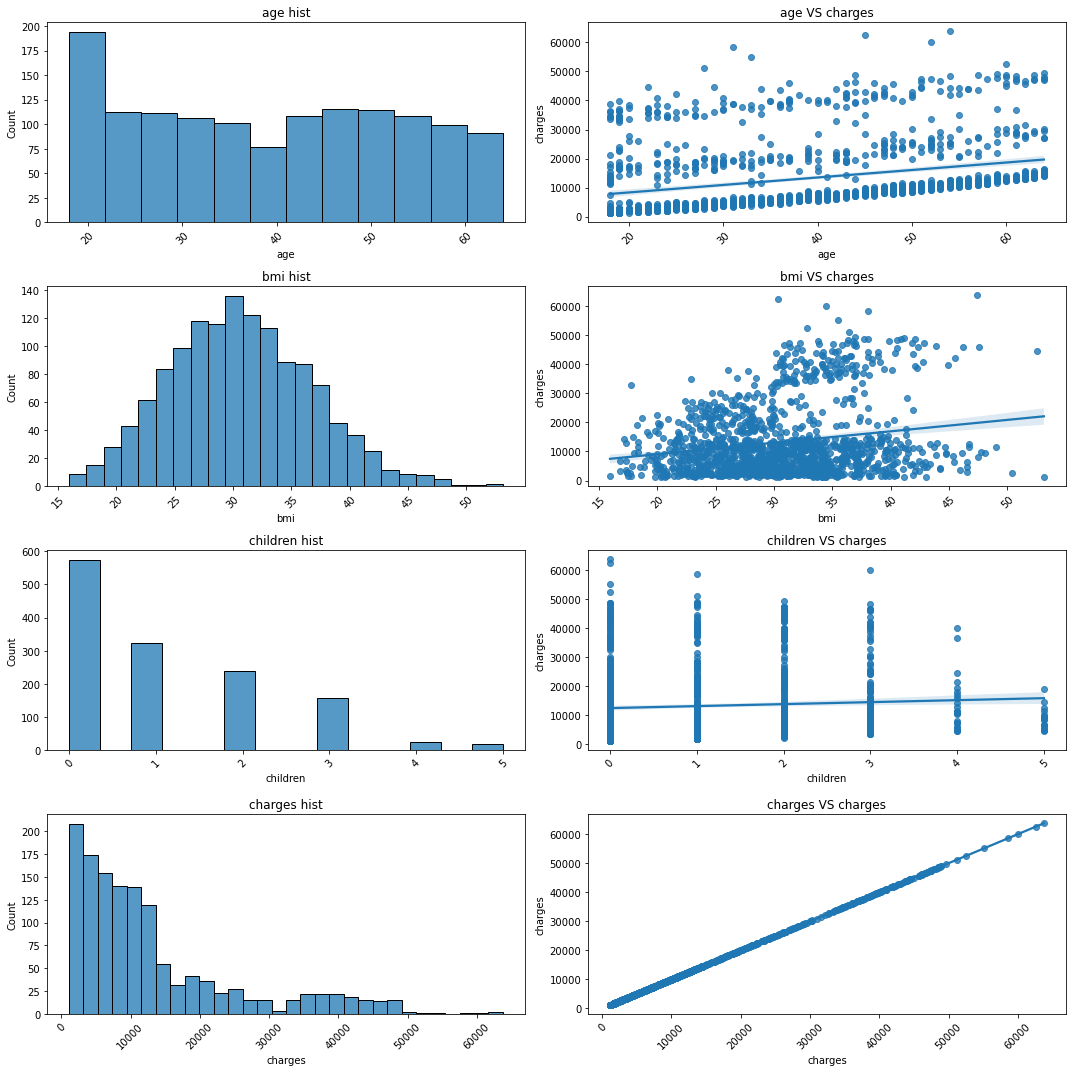

In [35]:
# Построение зависимостей для числовых признаков
n = len(num_type)
fig, axes = plt.subplots(n, 2, figsize=(15, 15)) # Создаем пространства для графиков 
for i, feature in enumerate(num_type):
    # Строим гистограмму распределения признака
    histplot = sns.histplot(data=temp_data, x=feature, ax=axes[i][0]) #i- индекс, feature - название признака в таблице
    # Добавляем подпись к графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=temp_data, x=feature, y='charges', ax=axes[i][1])
    # Добавляем подпись к графику
    regplot.set_title('{} VS charges'.format(feature));
    # Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
# Выравнивание графиков
plt.tight_layout()
    
    

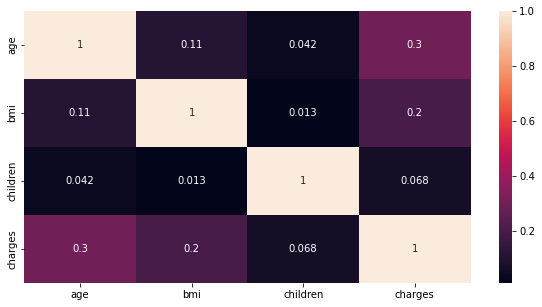

In [36]:
# Строим тепловую карту корреляции
fig = plt.figure(figsize=(10, 5))
sns.heatmap(temp_data.corr(), annot=True);

Подготовка данных

In [37]:
#кодируем бинарные категориальные признаки
temp_data['smoker'] = temp_data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
temp_data['sex'] = temp_data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
temp_data = pd.get_dummies(temp_data)
temp_data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [38]:
# Выделем факторы и целевой признак в разные таблицы
features = temp_data.drop('charges', axis=1).columns
X, y = temp_data[features], temp_data['charges']

In [39]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, # размер тестовой выборки
    random_state=42
)

#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


In [40]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [41]:
# Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
# Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
# Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888


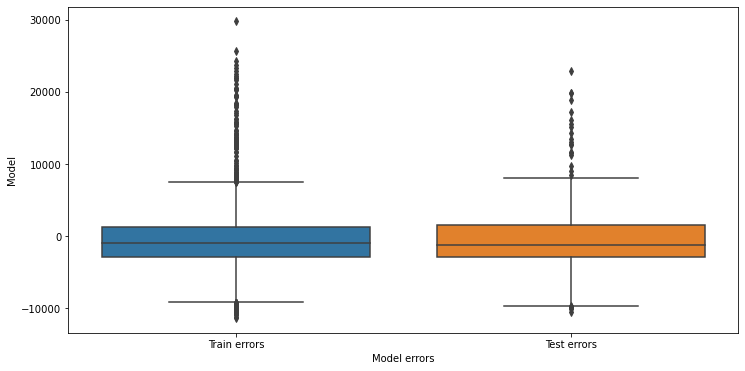

In [44]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат